In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#@title Load the Dataset
# Training data, test data, and RUL data are stored in Google Drive
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_FD001.txt', sep=' ', header=None).iloc[:, :-1]
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_FD001.txt', sep=' ', header=None).iloc[:, :-1]
rul_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RUL_FD001.txt', header=None)

In [ ]:
#@title Preprocess the Data
# Clean unnecessary columns
train_data = train_data.iloc[:, :23]
test_data = test_data.iloc[:, :23]

# Rename columns
columns = ['EngineID', 'Cycle'] + [f'Sensor_{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns

# Add Remaining Useful Life (RUL) column to the training set
train_data['RUL'] = train_data.groupby('EngineID')['Cycle'].transform(max) - train_data['Cycle']

# Drop low-variance sensors
low_variance_sensors = ['Sensor_1', 'Sensor_5', 'Sensor_10', 'Sensor_16', 'Sensor_18', 'Sensor_19']
train_data = train_data.drop(columns=low_variance_sensors)
test_data = test_data.drop(columns=low_variance_sensors)

<ipython-input-4-4fba447c1c84>:12: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  train_data['RUL'] = train_data.groupby('EngineID')['Cycle'].transform(max) - train_data['Cycle']


In [ ]:
#@title Normalize Sensor Data
# Normalize sensor values between 0 and 1
scaler = MinMaxScaler()
sensor_columns = [col for col in train_data.columns if 'Sensor' in col]
train_data[sensor_columns] = scaler.fit_transform(train_data[sensor_columns])
test_data[sensor_columns] = scaler.transform(test_data[sensor_columns])

In [ ]:
#@title Prepare Training and Testing Datasets
# Training features (X) and target (y)
X_train = train_data.drop(columns=['EngineID', 'Cycle', 'RUL'])
y_train = train_data['RUL']

# Testing features (X) and target (y)
rul_data.columns = ['RUL']
test_data = test_data.groupby('EngineID').last().reset_index()
test_data = test_data.merge(rul_data, left_on='EngineID', right_index=True)
X_test = test_data.drop(columns=['EngineID', 'Cycle', 'RUL'])
y_test = test_data['RUL']

In [ ]:
#@title Train the Random Forest Model
# Train a Random Forest Regressor for RUL prediction
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
#@title Make Predictions
# Predict RUL on the test data
y_pred = model.predict(X_test)

In [ ]:
#@title Evaluate the Model
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Model Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Model Evaluation:
RMSE: 69.59
R^2 Score: -1.80


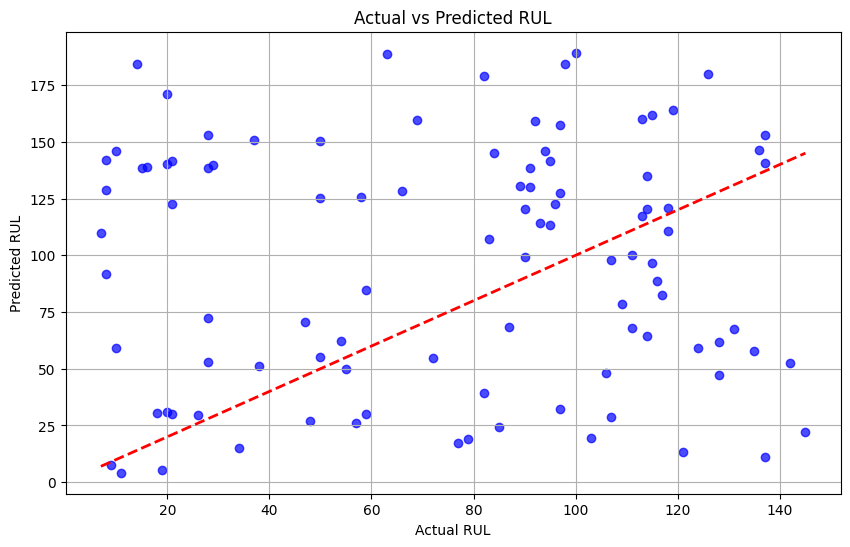

In [ ]:
#@title Visualize Actual vs Predicted RUL
# Scatter plot of actual vs predicted RUL
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.grid(True)
plt.show()

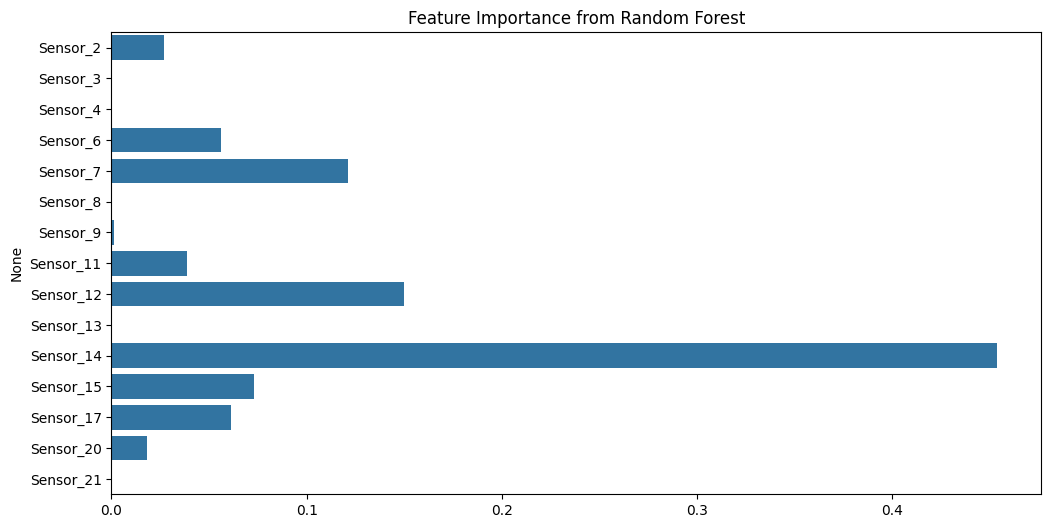

In [ ]:
#@title Feature Importance Analysis
# Analyze which sensors contributed the most to the predictions
feature_importance = model.feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=X_train.columns)
plt.title('Feature Importance from Random Forest')
plt.show()